In [2]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [3]:
#pip install fastai

In [4]:
#pip install efficientnet-pytorch

In [5]:
import fastai
print(fastai.__version__)  # Check the installed version

2.7.17


In [6]:
# Import required libraries
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import precision_score, recall_score, f1_score

# # Define the DataBlock
# dblock = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),  # Input: Image, Target: Category
#     get_items=get_image_files,  # Get all image files in the path
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Train/valid split
#     get_y=parent_label,  # Labels from parent folder names
#     item_tfms=Resize(460),  # Resize to 460 before batching
#     batch_tfms=aug_transforms(size=224)  # Resize to 224 with augmentations
# )

# # Load the DataLoaders
# path = Path('data/train19')
# dls = dblock.dataloaders(path, bs=8, num_workers=0)

# # Show a batch of images
# #dls.show_batch(max_n=9, figsize=(8, 8))

/home/lmanov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [7]:
# Alternative datablock implementation

print("---------------------------------------")
# path = '/home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/mariaherrerot/aptos2019'
# csv_path = os.path.join(path.strip(""), 'train_1.csv')
# img_folder = str(os.path.join(path, 'train_images/train_images/'))
# format  = ".png"
path = "/home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/benjaminwarner/resized-2015-2019-blindness-detection-images"
csv_path = os.path.join(path.strip(""), 'labels/trainLabels19.csv')
img_folder = str(os.path.join(path, 'resized train 19/'))
format  = ".jpg"

print(f"{csv_path} \n {img_folder}")
print("=====================================")



df = pd.read_csv(csv_path)
df[df.columns[0]] = df[df.columns[0]].apply(lambda x: x if x.endswith(format) else x  + format)
df = df[df[df.columns[0]].apply(lambda x: os.path.exists(os.path.join(img_folder, x)))]

print("Number of df columns: ", len(df.columns))
print(f"Number of rows in the dataframe: {len(df)}")
print(f"img_folder: {img_folder}")
print(f"csv_path: {csv_path}")
# Create a DataBlock and DataLoaders
random_splitter=RandomSplitter(valid_pct=0.2, seed=42) 
try:
    dblock = DataBlock(
    blocks=(ImageBlock , CategoryBlock),
    get_x=ColReader(df.columns[0], pref=img_folder),
    get_y=ColReader(df.columns[1]),            
    splitter = random_splitter,     
    item_tfms=Resize(size=460),    
    batch_tfms=aug_transforms(size=224))
except FileNotFoundError:
        print(f"File not found. Skipping to the next file.")
        pass

dls = dblock.dataloaders(df, bs=8, with_labels=True)


---------------------------------------
/home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/benjaminwarner/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv 
 /home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/benjaminwarner/resized-2015-2019-blindness-detection-images/resized train 19/
Number of df columns:  2
Number of rows in the dataframe: 3662
img_folder: /home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/benjaminwarner/resized-2015-2019-blindness-detection-images/resized train 19/
csv_path: /home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/benjaminwarner/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv


In [8]:
#Later on set as a function - Hard coded from the excel train 2015 Let's say these are the sample counts for each class
#class_counts = [25810, 2443, 5292, 873, 708]  # Replace with your actual class distribution
class_counts = [1805, 370, 999, 193, 295]  # Replace with your actual class distribution
# Compute weights inversely proportional to class frequency
class_weights = [1.0 / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

def get_sample_weights(dls, class_weights):
    sample_weights = []
    for idx in range(len(dls.train_ds)):
        label = dls.train_ds[idx][1]  # Get the label of each sample
        sample_weights.append(class_weights[label])
    return torch.tensor(sample_weights, dtype=torch.float32)

# Compute sample weights
sample_weights = get_sample_weights(dls, class_weights)

weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights),  # Number of samples in an epoch
    replacement=True  # Sampling with replacement
)

# Replace the default train DataLoader's sampler
dls.train.loader = torch.utils.data.DataLoader(
    dls.train_ds,
    batch_size=8,
    sampler=weighted_sampler,
    num_workers=0
)

In [9]:
class CustomModelMethods:
    """CustomModelMethods is a base class that defines methods for training and evaluating a model using FastAI."""

    def __init__(self):
        # Initialize without any learner
        self.class_learner = None

    def get_learner(self, dls, criterion, metrics):
        """Initializes a FastAI Learner with a given dataset, criterion, and metrics."""
        if self.class_learner is None:  # If learner doesn't exist, create one
            self.class_learner = Learner(dls, self, loss_func=criterion, metrics=metrics)
        return self.class_learner  # Return the initialized learner

    def train_model(self, dls, epochs=10, criterion=None, early_stopping=None):
        """Trains the model using FastAI Learner's fine_tune method for transfer learning or training from scratch."""
        if self.class_learner is None:  # Create learner if not already initialized
            # Initialize Learner with loss function
            self.class_learner = Learner(dls, self, loss_func=criterion, metrics=accuracy)
            self.class_learner.create_opt()  # Create the optimizer

        # Train for the specified number of epochs
        for epoch in range(epochs):
            train_loss = self.class_learner.fit_one_cycle(1)  # Train for one epoch
            val_loss = self.class_learner.validate()[0]  # Get validation loss
            print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

            # Check for early stopping
            if early_stopping and early_stopping(val_loss):
                print(f"Early stopping triggered after epoch {epoch + 1}.")
                break  # Exit training loop if early stopping is triggered

    def evaluate_model(self, dls):
        """Evaluates the model: generates confusion matrix, displays top losses, and calculates accuracy."""
        print("Using validation DataLoader for evaluation.")
        print(f"Validation DataLoader size: {len(dls.valid)}")

        if self.class_learner is None:
            self.class_learner = Learner(dls.valid, self, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

        # Check dataset sizes during evaluation
        print(f"Validation dataset size: {len(dls.valid_ds)}")
        print(f"Training dataset size: {len(dls.train_ds)}")

        # Print DataLoader sizes
        print(f"Training DataLoader size: {len(dls.train)}")
        print(f"Validation DataLoader size: {len(dls.valid)}")

        # Validate structure of the validation dataset
        print("Validating the structure of the validation dataset...")
        print(f"Sample validation data (first 5 items): {dls.valid_ds.items[:5]}")  # Print first 5 items

        # Correctly access the validation labels
        labels = [item[1] for item in dls.valid_ds.items]  # Assuming the second element is the label
        print(f"Sample validation labels (first 5): {labels[:5]}")  # Print first 5 labels

        # Generate metrics like confusion matrix and top losses
        interp = ClassificationInterpretation.from_learner(self.class_learner)

        # Get predictions and targets
        preds, targets = self.class_learner.get_preds(ds_idx=1)  # Ensures we use validation set

        # Check for any mismatch in lengths
        if preds.size(0) != targets.size(0):
            print(f"Mismatch detected! Predictions: {preds.size(0)}, Targets: {targets.size(0)}")
            # Truncate predictions or targets to the smaller size
            min_size = min(preds.size(0), targets.size(0))
            preds = preds[:min_size]
            targets = targets[:min_size]
            print(f"Using truncated sizes: {preds.size(0)} for both predictions and targets.")

        # Print the shape of the predictions and targets to diagnose any mismatch
        print(f"Shape of predictions: {preds.shape}")
        print(f"Shape of targets: {targets.shape}")

        # Print the first few predictions and targets for a quick sanity check
        print(f"Sample predictions: {preds[:10]}")
        print(f"Sample targets: {targets[:10]}")

        preds = torch.argmax(preds, dim=1)

        # Check for unique classes in targets and preds
        unique_targets = set(targets.numpy())
        unique_preds = set(preds.numpy())

        if len(unique_targets) == 0 or len(unique_preds) == 0:
            print("Warning: No valid classes present in targets or predictions.")
        else:
            print(f"Accuracy: {accuracy_score(targets, preds):.4f}")
            print('Classification Report:')
            print(classification_report(targets, preds, zero_division=0))  # Adjust zero_division as needed
            print('Confusion Matrix:')
            print(confusion_matrix(targets, preds))

            # Micro and Macro metrics
            micro_precision = precision_score(targets, preds, average='micro')
            micro_recall = recall_score(targets, preds, average='micro')
            micro_f1 = f1_score(targets, preds, average='micro')

            macro_precision = precision_score(targets, preds, average='macro')
            macro_recall = recall_score(targets, preds, average='macro')
            macro_f1 = f1_score(targets, preds, average='macro')

            print("\nMicro and Macro Averages:")
            print(f"Micro Precision: {micro_precision:.4f}")
            print(f"Micro Recall: {micro_recall:.4f}")
            print(f"Micro F1 Score: {micro_f1:.4f}")
            print(f"Macro Precision: {macro_precision:.4f}")
            print(f"Macro Recall: {macro_recall:.4f}")
            print(f"Macro F1 Score: {macro_f1:.4f}")

    def save_model(self, filename, mode='weights', pretrained_pkl_path=None):
        """Saves the model weights to the specified file or directory using Hugging Face's save_pretrained method."""
        if mode == 'weights':
            if hasattr(self.class_learner.model, 'save_pretrained'):
                #Issue fix: Using Hugging Face's save_pretrained method
                self.class_learner.model.save_pretrained(filename)  # Use Hugging Face method
                print(f"Hugging Face method - Model weights saved to {filename}.")
            else:
                torch.save(self.class_learner.model.state_dict(), filename)  # Fallback for non-Hugging Face models
                print(f"Model weights saved to {filename}.")
        elif mode == 'full':
            torch.save(self.class_learner, filename)
            print(f"Full model saved to {filename}.")
        else:
            raise ValueError("Invalid mode. Use 'full' or 'weights'.")

        # Export to pickle file from the learner
        if pretrained_pkl_path is not None:
            #Issue fix: Ensure compatibility with Hugging Face models
            self.class_learner.export(pretrained_pkl_path)
            print(f"Learner exported to {pretrained_pkl_path}.")

    def load_model(self, filename, mode='full'):
        """Loads the model weights or the full model from the specified file."""
        try:
            if filename.endswith('.pth') or filename.endswith('.pt'):
                if mode == 'weights':
                    self.class_learner.model.load_state_dict(torch.load(filename))
                    print(f"Model weights loaded from {filename}.")
                elif mode == 'full':
                    self.class_learner = torch.load(filename)  # Load the entire model
                    print(f"Full model loaded from {filename}.")
                else:
                    raise ValueError("Invalid mode. Use 'full' or 'weights'.")
            elif filename.endswith('.pkl'):
                self.class_learner = torch.load(filename)  # Load the entire learner from the pickle file
                print(f"Full model loaded from {filename}.")
            else:
                raise ValueError("Unsupported file extension. Use .pth, .pt, or .pkl.")

        except Exception as e:
            if mode == 'weights':
                #Issue fix: Attempt loading weights with strict=False for compatibility
                self.class_learner.model.load_state_dict(torch.load(filename, strict=False))
                print(f"Model weights loaded with strict=False from {filename}. Warning: {e}")
            elif mode == 'full':
                self.class_learner = torch.load(filename, strict=False)
                print(f"Full model loaded with strict=False from {filename}. Warning: {e}")
            else:
                print(f"An error occurred: {e}. Invalid mode. Use 'full' or 'weights'.")


In [10]:
class PretrainedEyeDiseaseClassifier(nn.Module, CustomModelMethods):
    """A pretrained model for classifying eye diseases using transfer learning. Supports VGG16, ResNet18, or EfficientNet-B7."""

    def __init__(self, num_classes=5, pretrained_model='vgg16'):
        nn.Module.__init__(self)  # Initialize PyTorch's nn.Module
        CustomModelMethods.__init__(self)  # Initialize methods for training/evaluation from the CustomModelMethods class
        print("Initializing PretrainedEyeDiseaseClassifier...")

        # Initialize num_ftrs as an instance variable
        self.num_ftrs = None

        # Choose between VGG16, ResNet18, or EfficientNet-B7 pretrained models
        if pretrained_model == 'vgg16':
            self.model = models.vgg16(pretrained=True)  # Load pretrained VGG16 model
            self.num_ftrs = 4096  # Set num_ftrs for VGG16
            self.model.classifier[6] = nn.Linear(self.num_ftrs, num_classes)  # Replace final layer for `num_classes`
            print("Using VGG16 model.")
        elif pretrained_model == 'resnet18':
            self.model = models.resnet18(pretrained=True)  # Load pretrained ResNet18 model
            self.num_ftrs = self.model.fc.in_features  # Get the number of input features for the final layer
            self.model.fc = nn.Linear(self.num_ftrs, num_classes)  # Replace final layer with a custom one
            print("Using ResNet18 model.")
        elif pretrained_model == 'efficientnet-b7':
            # model = models.efficientnet_b7(weights= EfficientNet_B7_Weights.IMAGENET1K_V1)                
            # num_ftrs = model.classifier[1].in_features                
            # model.classifier[1] = nn.Linear(num_ftrs, num_classes)
            # print("Using torch models  EfficientNet-B7 model.")
            self.model = EfficientNet.from_pretrained('efficientnet-b7')  # Load pretrained EfficientNet-B7 model
            self.num_ftrs = self.model._fc.in_features  # Get the number of input features for the final layer
            self.model._fc = nn.Linear(self.num_ftrs, num_classes)  # Replace final layer with a custom one
            print("Using EfficientNet-B7 model.")
        else:
            raise ValueError("Unsupported pretrained model. Choose 'vgg16', 'resnet18', or 'efficientnet-b7'.")

    def create_fc_layers(self, num_classes, num_ftrs):
        """Creates custom fully connected layers connected to the pretrained model's output."""
        print("Creating fully connected layers...")
        return nn.Sequential(
            nn.Linear(num_ftrs, 512),  # First fully connected layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, 256),  # Second fully connected layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(256, num_classes)  # Final layer for classification
        )

    def forward(self, x):
        """Forward pass for the model, which applies the pretrained model's forward pass.
        every batch processed during training or validation calls the forward method,
        and you have a print statement inside that method. so comment it
        """

        ##print("Performing forward pass...")
        x = self.model(x)  # Pass input through the model
        return x  # Return the output from the model
    
    # This attribute needed by TensorBoardCallback
    def update_smooth_loss(self, loss, beta=0.98):
        # Update smooth_loss with the new loss value 
        self.smooth_loss = beta * self.smooth_loss + (1 - beta) * loss.item() 
        return self.smooth_loss

    def set_num_classes(self, num_classes):
        """Dynamically adjust the final layer to accommodate a new number of classes."""
        print("Setting number of classes...")
        if isinstance(self.model, models.VGG):
            self.model.classifier[6] = nn.Linear(self.num_ftrs, num_classes)  # Update VGG final layer
        elif isinstance(self.model, models.ResNet):
            self.model.fc = nn.Linear(self.num_ftrs, num_classes)  # Update ResNet final layer
        elif isinstance(self.model, EfficientNet):
            self.model._fc = nn.Linear(self.num_ftrs, num_classes)  # Update EfficientNet final layer

        print(f"Number of classes updated to {num_classes}.")  # Confirmation message

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom precision with zero_division handling for macro average
def precision_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='macro', zero_division=1)

def precision_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='micro', zero_division=1)

# Custom recall with zero_division handling for macro average
def recall_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='macro', zero_division=1)

def recall_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='micro', zero_division=1)

# Custom f1 score with zero_division handling for macro average
def f1score_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='macro', zero_division=1)

def f1score_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='micro', zero_division=1)

In [12]:
class EarlyStopping:
    """
    EarlyStopping monitors the validation loss during training and stops the training process
    if the loss does not improve after a specified number of epochs (patience).

    Attributes:
    - patience: The number of epochs to wait for improvement before stopping.
    - min_delta: Minimum change in the monitored quantity to qualify as an improvement.
    - counter: Counts the number of epochs without improvement.
    - best_loss: Stores the best validation loss encountered during training.
    - stopped_epoch: Records the epoch number when training was stopped.
    """

    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def __call__(self, val_loss):
        """
        Checks the validation loss to determine if training should stop.

        Parameters:
        - val_loss: The current validation loss to check against the best loss.

        Returns:
        - bool: True if training should stop, otherwise False.
        """
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if there's improvement
        else:
            self.counter += 1  # Increment counter if no improvement

        if self.counter >= self.patience:
            self.stopped_epoch = self.counter
            return True  # Stop training

        return False  # Continue training

Initializing PretrainedEyeDiseaseClassifier...
Loaded pretrained weights for efficientnet-b7
Using EfficientNet-B7 model.
Single batch tensor dimensions: torch.Size([8, 3, 224, 224])


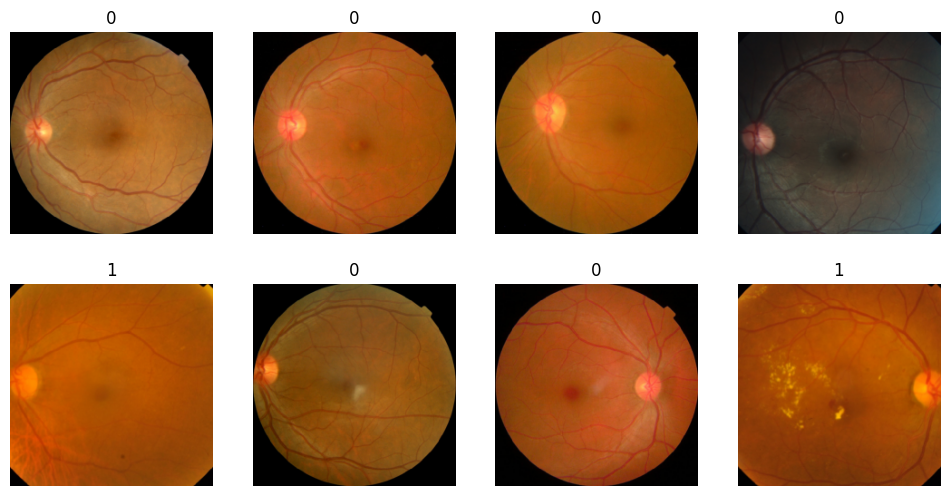

In [13]:
# clear garbage
# import gc
# gc.collect()

# Initialize the Model
model = PretrainedEyeDiseaseClassifier(pretrained_model='efficientnet-b7', num_classes=5)

early_stopping = EarlyStopping(patience=5)

# Show a batch of images from the validation DataLoader
dls.valid.show_batch()
batch = dls.valid.one_batch()
print(f"Single batch tensor dimensions: {batch[0].shape}")

In [ ]:
# Create the FAST AI Learner
import datetime
# !pip install torch  
# !pip install fastai
# !pip install torchvision
# !pip install torchmetrics
# !pip install torchinfo
# !pip install torchsummary
# !pip install numpy
import torchvision.models 
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.vision.all import *
import subprocess
import os
import torch
import fastai
print(f"FastAI version: {fastai.__version__}")
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.tracker import EarlyStoppingCallback
from torch.utils.tensorboard import SummaryWriter
model_name = 'v4.6_efficientnet-b7_model'

#%rm -rf "logs/fine_tune/" + model_name
#%rm -rf "runs/" + model_name

datetimestr = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir="logs/fine_tune/" + model_name + '/' + datetimestr
# Create a SummaryWriter 
writer = SummaryWriter('runs/' + model_name + '/' + datetimestr)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam, lr=0.001),
    metrics=[
        accuracy,
        precision_micro, recall_micro, f1score_micro,
        precision_macro, recall_macro, f1score_macro
    ],
    cbs=[  TensorBoardCallback(log_dir=logdir, trace_model=True),  EarlyStoppingCallback(monitor='valid_loss', patience=5)]    
    )
       

LoadFromFile = True
learn = model.get_learner(dls, CrossEntropyLossFlat(), [accuracy, precision_micro, recall_micro, f1score_micro, precision_macro, recall_macro, f1score_macro])
if LoadFromFile:
    #learn.load('v4.6_efficientnet-b7_model')    
    model = torch.load(model_name + '.pth')    
    learn.model = model 
    learn.create_opt()    
    print(f"Type of learn: {type(learn)}")
    print(f"Type of model: {type(model)}")
    print(f"learn.device: {learn.dls.device}")
else:    

    learn.create_opt()  
    # Train the Model
    epochs= 10
    for epoch in range(epochs):
        # Train for one epoch
        learn.fit_one_cycle(1)

        # Get training loss directly from the recorder
        if learn.recorder.values and len(learn.recorder.values) > 0 and len(learn.recorder.values[-1]) > 0:
            train_loss = learn.recorder.values[-1][0]
            smooth_loss = learn.model.update_smooth_loss(train_loss)
        else:
            train_loss = 'N/A'
            smooth_loss = 'N/A'

        val_loss = learn.validate()[0]  # Get validation loss
        # Print training and validation losses if available, otherwise indicate 'N/A'
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss:.4f}")

        # Check for early stopping
        if early_stopping and early_stopping(val_loss):
            print(f"Early stopping triggered after epoch {epoch + 1}.")
            break  # Exit training loop if early stopping is triggered

        # Save the state_dict (model parameters)
        #torch.save(model, "models/v4.6_efficientnet-b7_model.pt")
        torch.save(model, "models/v4.6_efficientnet-b7_model.pth")
        #torch.save(model, "models/v4.6_efficientnet-b7_model.pkl")



2024-11-10 21:15:21.814578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731266121.980449  690144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731266122.027701  690144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 21:15:22.508465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


FastAI version: 2.7.17
Type of learn: <class 'fastai.learner.Learner'>
Type of model: <class '__main__.PretrainedEyeDiseaseClassifier'>
learn.device: cuda:0


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Custom function to generate a report after training
def evaluate_model(learner, dl):
    preds, targs = learner.get_preds(dl=dl)
    preds = preds.argmax(dim=1).cpu().numpy()
    targets = targs.cpu().numpy()

    # Accuracy
    acc = accuracy_score(targets, preds)
    print(f"Accuracy: {acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(targets, preds, zero_division=1))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(targets, preds))

    micro_precision = precision_score(targets, preds, average='micro')
    micro_recall = recall_score(targets, preds, average='micro')
    micro_f1 = f1_score(targets, preds, average='micro')

    macro_precision = precision_score(targets, preds, average='macro')
    macro_recall = recall_score(targets, preds, average='macro')
    macro_f1 = f1_score(targets, preds, average='macro')

    print("\nMicro and Macro Averages:")
    print(f"Micro Precision: {micro_precision:.4f}")
    print(f"Micro Recall: {micro_recall:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")

# Call this function after training, passing the validation dataloader
#evaluate_model(learn, dls.valid)


In [16]:
#!pip install torchviz
import torch 
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchviz import make_dot 
import tensorflow as tf 

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import itertools
from fastai.vision.core import PILImage
from packaging import version
import tensorboard as tb

print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
major_ver, minor_ver, _ = version.parse(tb.__version__).release
print("TensorBoard version: ", tb.__version__)

class_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'] 

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, tensorboard_writer=None):
    fig_cm, ax = plt.subplots(figsize=(8, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            text = f"{cm[i, j]:.2f}"
        else:
            text = f"{int(cm[i, j])}"
        plt.text(j, i, text, horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    
    plt.show()
    if tensorboard_writer:
        tensorboard_writer.add_figure(title, fig_cm)
    return fig_cm


def plot_roc_auc(class_names , targets, preds, tensorboard_writer):
        # ROC and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(targets == i, preds == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    fig_roc, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(class_names)):
        ax.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    if tensorboard_writer:
        tensorboard_writer.add_figure('ROC Curves', fig_roc)
    return fig_roc



# Function to plot sample predictions
def plot_sample_predictions(dls, preds, targets, img_path='' , tensorboard_writer=None):
    """
    Plot sample predictions for FastAI vision classification
    
    Parameters:
    dls: FastAI DataLoaders
    preds: Model predictions
    targets: True labels
    img_path: Base path to the images directory (if needed)
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # Get the first 10 items from validation dataset
    items = dls.valid_ds.items[:10]
    for i, (item, pred, target) in enumerate(zip(items.itertuples(), preds[:10], targets[:10])):
        try:
            # Construct full image path
            img_filename = item.id_code            
            if img_path:
                full_path = os.path.join(img_path, img_filename)
            else:
                full_path = img_filename
                
            # Load and display image
            img = Image.open(full_path)
            axes[i].imshow(img)
            axes[i].set_title(f'True: {class_names[target]}\nPred: {class_names[pred]}')
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error processing image {img_filename}: {str(e)}")
            axes[i].text(0.5, 0.5, 'Error loading image', 
                        ha='center', va='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

    if tensorboard_writer:      
        tensorboard_writer.add_figure('Sample Predictions', fig)
    return fig




TensorFlow version: 2.18.0
PyTorch version: 2.2.2+cu121
TensorBoard version:  2.18.0


## Evaluate model and add different metrics to a tensorboard

In [17]:
# clear garbage
# import gc
# gc.collect()
# Ensure the model is on the same device as the input batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch = dls.valid.one_batch()
batch = [b.to(device) for b in batch]  # Move batch to the same device as the model

# Forward pass through the model 
output = model(batch[0])

# Add the model graph to TensorBoard 
writer.add_graph(model, (batch[0]))

# Create a visualization of the model 
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
graph_file_name = model_name + '_model_graph'
dot.render(graph_file_name, format="png")

torchvision_graph_file = graph_file_name + '.png'
# writer.add_image('Model Graph', torchvision_graph_file)
# Get predictions and targets 
preds, targets = learn.get_preds(dl=dls.valid) 
print(f'Predictions: {preds[:5]}, Targets: {targets[:5]}') 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.224384 to fit


Predictions: tensor([[9.9911e-01, 2.7765e-04, 8.0044e-05, 2.5416e-04, 2.7842e-04],
        [9.9798e-01, 1.6073e-03, 1.5999e-04, 5.7522e-05, 1.9073e-04],
        [9.9704e-01, 2.2503e-03, 2.6674e-04, 1.0604e-04, 3.4112e-04],
        [9.9897e-01, 6.7478e-04, 2.0513e-04, 3.7078e-05, 1.1186e-04],
        [3.5072e-02, 8.7600e-01, 8.5413e-02, 4.2979e-04, 3.0800e-03]]), Targets: tensor([0, 0, 0, 0, 1])


Show sample predictions..


Plotting top losses...


Most confused classes:
[(1, 2, 22), (3, 2, 20), (4, 2, 16), (2, 1, 15), (3, 4, 9), (0, 1, 5), (1, 0, 4), (2, 3, 4), (2, 4, 3)]
Most Confused Classes
1: Mild DR (1) vs Moderate DR (2) : (22 samples)
2: Severe DR (3) vs Moderate DR (2) : (20 samples)
3: Proliferative DR (4) vs Moderate DR (2) : (16 samples)
4: Moderate DR (2) vs Mild DR (1) : (15 samples)
5: Severe DR (3) vs Proliferative DR (4) : (9 samples)
6: No DR (0) vs Mild DR (1) : (5 samples)
7: Mild DR (1) vs No DR (0) : (4 samples)
8: Moderate DR (2) vs Severe DR (3) : (4 samples)
9: Moderate DR (2) vs Proliferative DR (4) : (3 samples)



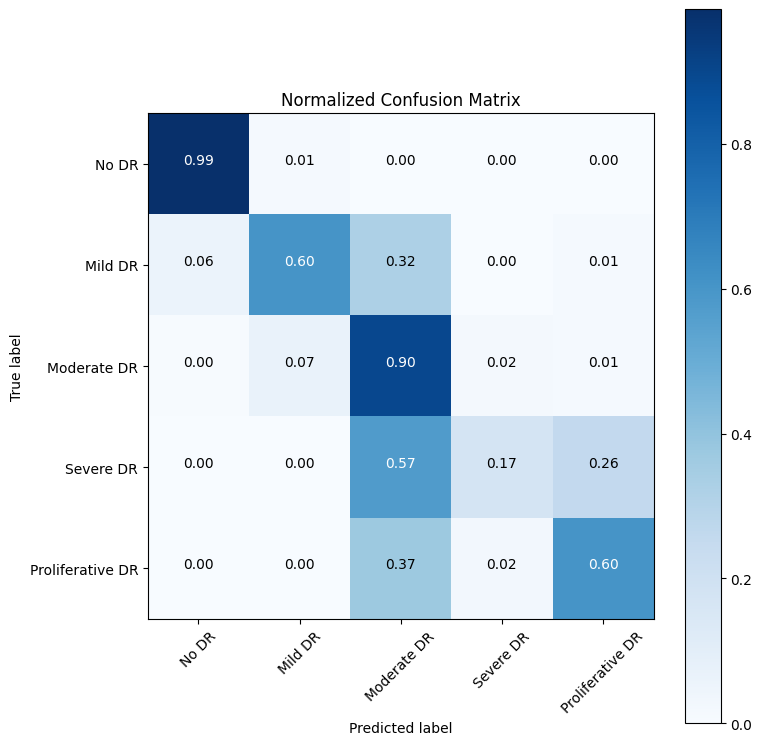

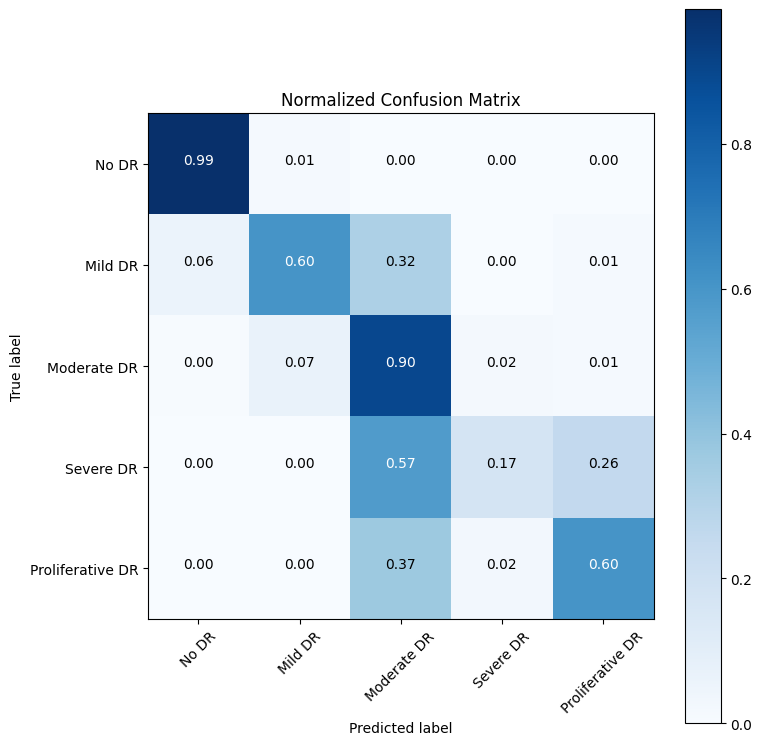

In [18]:
#!pip install torchviz
import torch 
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchviz import make_dot 
import tensorflow as tf 
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import itertools
from fastai.vision.core import PILImage
from packaging import version
import tensorboard as tb

# Show results (sample predictions) 
print("Show sample predictions..")
learn.show_results() 
fig = plt.gcf()  # Get the current figure
writer.add_figure('Sample Predictions', fig)
plt.show()  # Ensure the plot is displayed
plt.close(fig)

# Interpret the model 
interp = ClassificationInterpretation.from_learner(learn) 

conf_preds = np.argmax(preds, axis=1)
conf_targets = targets.numpy()

# Plot top losses
print("Plotting top losses...")
interp.plot_top_losses(k=5)
interp_tl = plt.gcf()  # Get the current figure
# Add legend to the plot
handles, labels = interp_tl.get_axes()[0].get_legend_handles_labels()
interp_tl.legend(handles, class_names, loc='upper right')
writer.add_figure('Top Losses', interp_tl)
plt.show()  # Ensure the plot is displayed
plt.close(interp_tl)

most_confused = interp.most_confused(min_val=2)
print("Most confused classes:")
print(most_confused)
most_confused_text = ""
for i, (predicted, actual, count) in enumerate(most_confused):
    most_confused_text += str(f"{i + 1}: {class_names[predicted]} ({predicted}) vs {class_names[actual]} ({actual}) : ({count} samples)")  
    most_confused_text += "\n" 
writer.add_text('Most Confused Classes', most_confused_text)
print('Most Confused Classes\n' + most_confused_text)

# Confusion matrix
cm = confusion_matrix(conf_targets, conf_preds)
# Plot confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix', tensorboard_writer=writer)

Classification Report (external to learn)
                  precision    recall  f1-score   support

           No DR      0.986     0.986     0.986       366
         Mild DR      0.672     0.603     0.636        68
     Moderate DR      0.773     0.895     0.829       220
       Severe DR      0.545     0.171     0.261        35
Proliferative DR      0.667     0.605     0.634        43

        accuracy                          0.862       732
       macro avg      0.729     0.652     0.669       732
    weighted avg      0.853     0.862     0.851       732

{'No DR': {'precision': 0.9863387978142076, 'recall': 0.9863387978142076, 'f1-score': 0.9863387978142076, 'support': 366.0}, 'Mild DR': {'precision': 0.6721311475409836, 'recall': 0.6029411764705882, 'f1-score': 0.6356589147286822, 'support': 68.0}, 'Moderate DR': {'precision': 0.7725490196078432, 'recall': 0.8954545454545455, 'f1-score': 0.8294736842105264, 'support': 220.0}, 'Severe DR': {'precision': 0.5454545454545454, 'recal

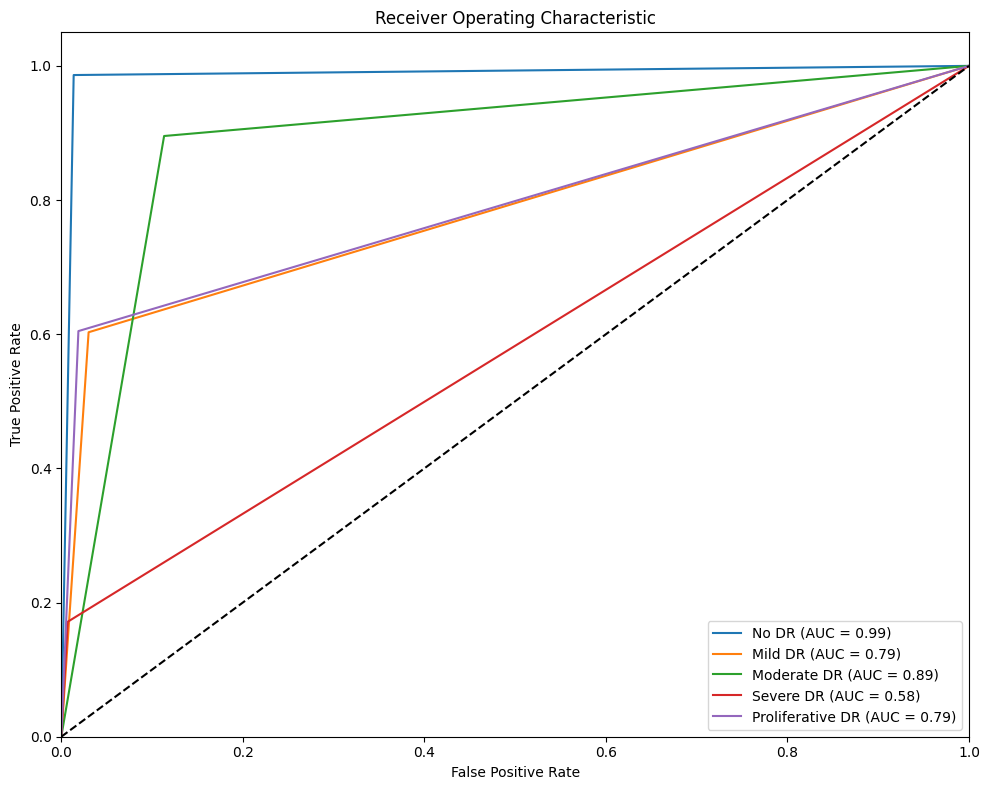

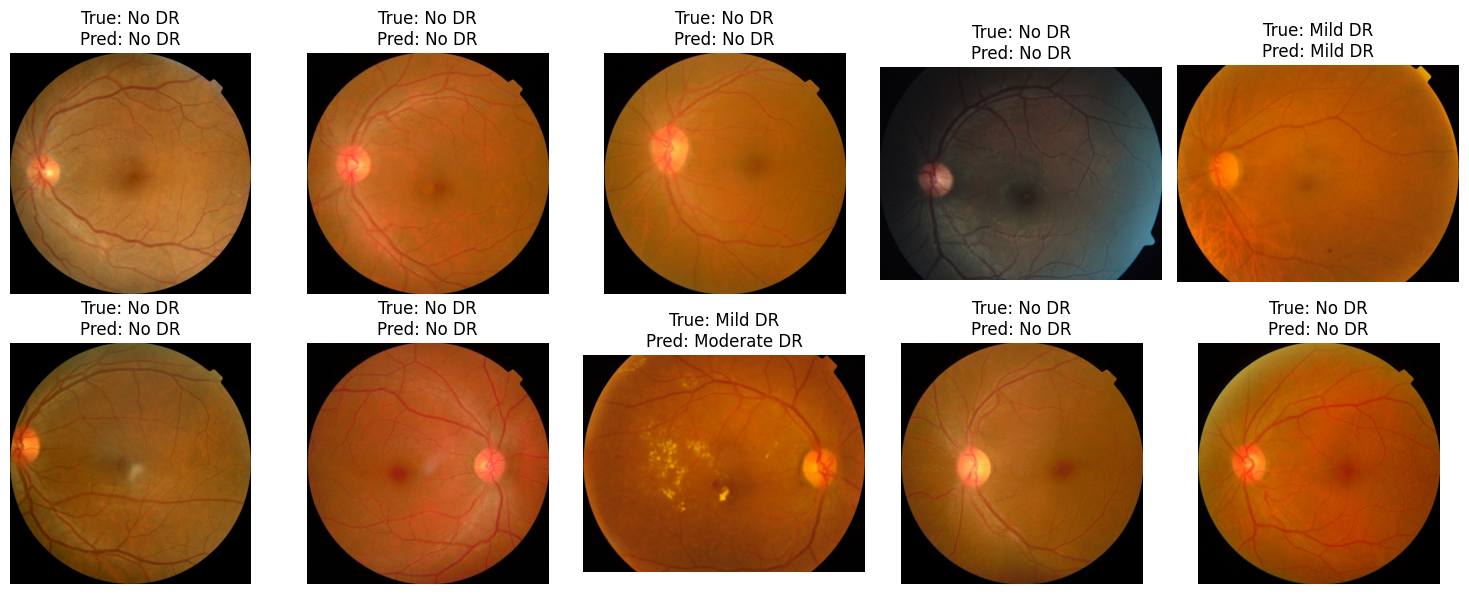

In [19]:

# Convert targets and predictions to numpy arrays if they aren't already
class_targets = np.array(targets)
class_preds = np.argmax(preds, axis=1)  # Convert continuous predictions to discrete class labels
# Generate the classification report
print("Classification Report (external to learn)")
report_text = classification_report(
    y_true=class_targets,
    y_pred=class_preds,
    target_names=class_names,
    digits=3
)
print(report_text)
writer.add_text('Classification Report', report_text)


# Classification report
report = classification_report(class_targets, class_preds, target_names=class_names, output_dict=True)
print(report)
# Log Precision, Recall, F1-score, and Accuracy
for label, metrics in report.items():
    if label == 'accuracy':
        writer.add_scalar(f'Accuracy', metrics, 1)
    else:
        for metric_name, value in metrics.items():
            writer.add_scalar(f'{label}/{metric_name.capitalize()}', value, 1)

# ROC AUC
print("Plotting ROC AUC...")
plot_roc_auc(class_names, class_targets, class_preds, tensorboard_writer=writer)
# Plot and log sample predictions
fig_preds = plot_sample_predictions(dls, class_preds, class_targets, img_folder, tensorboard_writer= writer)
writer.add_figure('Sample Predictions', fig_preds)

writer.close()

# img = mpimg.imread(torchvision_graph_file)
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

